<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Base-case" data-toc-modified-id="Base-case-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Base case</a></span></li><li><span><a href="#Base-model" data-toc-modified-id="Base-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Base model</a></span></li><li><span><a href="#Feature-engineering" data-toc-modified-id="Feature-engineering-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Feature engineering</a></span></li><li><span><a href="#Convergence-to-minimum-(SHAP)" data-toc-modified-id="Convergence-to-minimum-(SHAP)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Convergence to minimum (SHAP)</a></span></li></ul></div>

In [1]:
from lightgbm.sklearn import LGBMClassifier
from sklearn.metrics import log_loss
pd.options.display.max_rows=300

params = {
    "max_depth":-1,
    "learning_rate":.01,
    "n_estimators":1000,
    "objective":"binary",
    "device":"gpu",
    "random_state":42
}

lgb = LGBMClassifier(**params)

train_ = pd.read_pickle("./train_115.pkl")
x = train_.date.dt.year
train = train_[x<=2012]
test = train_[((2012<x)&(x<=2015))]

y_train = train["target"]
X_train = train.drop("target",1)
y_test = test["target"]
X_test = test.drop("target",1)

train.columns

Index(['date', 'idx', 'f__buytransactions_1m', 'f__selltransactions_1m',
       'f__buyshares_1m', 'f__sellshares_1m', 'f__buysharespctsharesout_1m',
       'f__sellsharespctsharesout_1m', 'f__uniquebuyers_1m',
       'f__uniquesellers_1m', 'f__buytransactions_3m',
       'f__selltransactions_3m', 'f__buyshares_3m', 'f__sellshares_3m',
       'f__buysharespctsharesout_3m', 'f__sellsharespctsharesout_3m',
       'f__uniquebuyers_3m', 'f__uniquesellers_3m', 'f__buytransactions_6m',
       'f__selltransactions_6m', 'f__buyshares_6m', 'f__sellshares_6m',
       'f__buysharespctsharesout_6m', 'f__sellsharespctsharesout_6m',
       'f__uniquebuyers_6m', 'f__uniquesellers_6m', 'f__buytransactions_12m',
       'f__selltransactions_12m', 'f__buyshares_12m', 'f__sellshares_12m',
       'f__buysharespctsharesout_12m', 'f__sellsharespctsharesout_12m',
       'f__uniquebuyers_12m', 'f__uniquesellers_12m', 'target', 'cnt'],
      dtype='object')

# Base case

In [2]:
log_loss(y_train,np.ones_like(y_train)/2)

0.693147180559946

# Base model

In [3]:
num_cols = X_train.select_dtypes(include="number").columns
lgb.fit(X_train[num_cols], y_train)
log_loss(y_train, lgb.predict_proba(X_train[num_cols]))
#0.6458755547393696
#0.6458558605997866
#0.6459021807097592

0.645888125362814

# Feature engineering

1. Dates  

2. buytrans minus selltrans:
    - 1M
    - 3M
    - 6M
    - 12M

3. buyshares plus sellshares (**sellshares are negative!!!**):
    - 1M
    - 3M
    - 6M
    - 12M

4. uniqubuyers minus uniquesellers:
    - 1M
    - 3M
    - 6M
    - 12M

5. buysharespctsharesout plus sellsharespctsharesout (**sellshares are negative!!!**):
    - 1M
    - 3M
    - 6M
    - 12M

6. buytrans 1m minus:
    - 3M
    - 6M
    - 12M

7. selltrans 1m minus:
    - 3M
    - 6M
    - 12M

8. buyshares 1M minus:
    - 3M
    - 6M
    - 12M

9. sellshares 1M minus:
    - 3M
    - 6M
    - 12M

10. unique buyers 1M minus:
    - 3M
    - 6M
    - 12M

12. unique sellers 1M minus:
    - 3M
    - 6M
    - 12M

13. buysharespctsharesout 1M minus:
    - 3M
    - 6M
    - 12M

14. sellsharespctsharesout 1M minus:
    - 3M
    - 6M
    - 12M

In [4]:
def add_date(df):
    df["year"] = df["date"].dt.year.astype("int32")
    df["month"] = df["date"].dt.month.astype("int32")
    df["quarter"] = df["date"].dt.quarter.astype("int32")
    df["week"] = df["date"].dt.isocalendar().week.astype("int32")
    df["day"] = df["date"].dt.dayofyear.astype("int32")
    df["btrs_strs_1m"] = df["f__buytransactions_1m"] - df["f__selltransactions_1m"]
    df["btrs_strs_3m"] = df["f__buytransactions_3m"] - df["f__selltransactions_3m"]
    df["btrs_strs_6m"] = df["f__buytransactions_6m"] - df["f__selltransactions_6m"]
    df["btrs_strs_12m"] = df["f__buytransactions_12m"] - df["f__selltransactions_12m"]
    df["bshrs_sshrs_1m"] = df["f__buyshares_1m"] - df["f__sellshares_1m"]
    df["bshrs_sshrs_3m"] = df["f__buyshares_3m"] - df["f__sellshares_3m"]
    df["bshrs_sshrs_6m"] = df["f__buyshares_6m"] - df["f__sellshares_6m"]
    df["bshrs_sshrs_12m"] = df["f__buyshares_12m"] - df["f__sellshares_12m"]
#############45
    df["unqb_unqs_1m"] = df["f__uniquebuyers_1m"] - df["f__uniquesellers_1m"]
    df["unqb_unqs_3m"] = df["f__uniquebuyers_3m"] - df["f__uniquesellers_3m"]
    df["unqb_unqs_6m"] = df["f__uniquebuyers_6m"] - df["f__uniquesellers_6m"]
    df["unqb_unqs_12m"] = df["f__uniquebuyers_12m"] - df["f__uniquesellers_12m"]
    df["bpct_spct_1m"] = (
        df["f__buysharespctsharesout_1m"] + df["f__sellsharespctsharesout_1m"]
    )
    df["bpct_spct_3m"] = (
        df["f__buysharespctsharesout_3m"] + df["f__sellsharespctsharesout_3m"]
    )
    df["bpct_spct_6m"] = (
        df["f__buysharespctsharesout_6m"] + df["f__sellsharespctsharesout_6m"]
    )
    df["bpct_spct_12m"] = (
        df["f__buysharespctsharesout_12m"] + df["f__sellsharespctsharesout_12m"]
    )
#############
    df['btrs1m_btrs3m'] = df["f__buytransactions_1m"] - df["f__buytransactions_3m"]
    df['btrs1m_btrs6m'] = df["f__buytransactions_1m"] - df["f__buytransactions_6m"]
    df['btrs1m_btrs12m'] = df["f__buytransactions_1m"] - df["f__buytransactions_12m"]
    df['strs1m_strs3m'] = df["f__selltransactions_1m"] - df["f__selltransactions_3m"]
    df['strs1m_strs6m'] = df["f__selltransactions_1m"] - df["f__selltransactions_6m"]
#############60
    df['strs1m_strs12m'] = df["f__selltransactions_1m"] - df["f__selltransactions_12m"]
    df['bsrs1m_bshrs3m'] = df["f__buyshares_1m"] - df["f__buyshares_3m"]
    df['bsrs1m_bshrs6m'] = df["f__buyshares_1m"] - df["f__buyshares_6m"]
    df['bsrs1m_bshrs12m'] = df["f__buyshares_1m"] - df["f__buyshares_12m"]
    df['sshrs1m_sshrs3m'] = df["f__sellshares_1m"] - df["f__sellshares_3m"]
    df['sshrs1m_sshrs6m'] = df["f__sellshares_1m"] - df["f__sellshares_6m"]
    df['sshrs1m_sshrs12m'] = df["f__sellshares_1m"] - df["f__sellshares_12m"]
    df['unqb1m_unqb3m'] = df['f__uniquebuyers_1m'] - df['f__uniquebuyers_3m'] 
    df['unqb1m_unqb6m'] = df['f__uniquebuyers_1m'] - df['f__uniquebuyers_6m']
    df['unqb1m_unqb12m'] = df['f__uniquebuyers_1m'] - df['f__uniquebuyers_12m'] 
    df['unqs1m_unqs3m'] = df["f__uniquesellers_1m"] - df["f__uniquesellers_3m"]
    df['unqs1m_unqs6m'] = df["f__uniquesellers_1m"] - df["f__uniquesellers_6m"]
    df['unqs1m_unqs12m'] = df["f__uniquesellers_1m"] - df["f__uniquesellers_12m"]
    df["bpct1m_bpct3m"] = df["f__buysharespctsharesout_1m"] - df["f__buysharespctsharesout_3m"]
    df["bpct1m_bpct6m"] = df["f__buysharespctsharesout_1m"] - df["f__buysharespctsharesout_6m"]
    df["bpct1m_bpct12m"] = df["f__buysharespctsharesout_1m"] - df["f__buysharespctsharesout_12m"]
    df["spct1m_spct3m"] = df["f__sellsharespctsharesout_1m"] - df["f__sellsharespctsharesout_3m"]
    df["spct1m_spct6m"] = df["f__sellsharespctsharesout_1m"] - df["f__sellsharespctsharesout_6m"]
    df["spct1m_spct12m"] = df["f__sellsharespctsharesout_1m"] - df["f__sellsharespctsharesout_12m"]

add_date(X_train)
add_date(X_test)

### Choose num of features: 45,55,60
num_cols = X_train.select_dtypes(include="number").columns[:45]

# LightGBM employes a peculiar [strategy](https://datascience.stackexchange.com/questions/65956/how-do-gbm-algorithms-handle-missing-data)  to handle missing values. Imputing missing values will make it worse:

lgb.fit(X_train[num_cols], y_train)
log_loss(y_train, lgb.predict_proba(X_train[num_cols]))
# 0.6445713097267892
# 0.6446687021689067
# 0.6445713109503719
# 0.6447565903932139
# 0.6446061969954247

0.6447134307610705

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


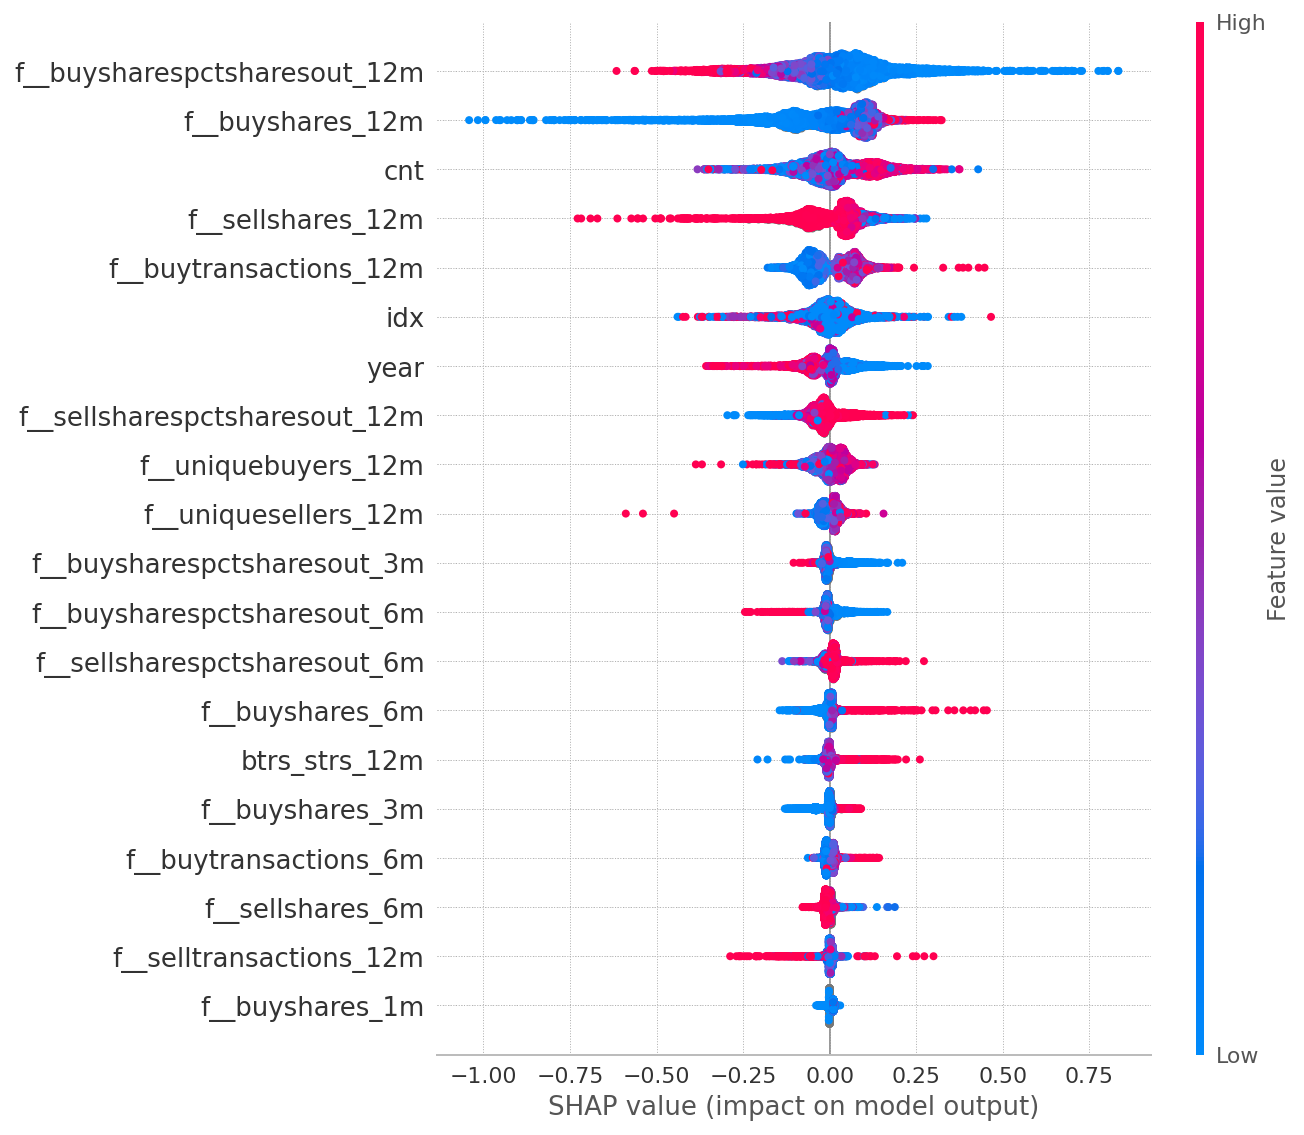

In [5]:
import shap
x = X_train.sample(frac=.01)
from shap import TreeExplainer, summary_plot
explainer = TreeExplainer(lgb)
sv = explainer.shap_values(x[num_cols])
summary_plot(sv[1],x[num_cols])

# Convergence to minimum (SHAP)

In [6]:
x = X_train[num_cols]
sv_cols = x.columns[np.abs(sv[1]).mean(0).argsort()[::-1]]
print("Total cols:",len(sv_cols))
print(sv_cols)
min_ll = 1
ll_shap = []
for i in tqdm(range(len(sv_cols))):
    lgb.fit(X_train[sv_cols[:i]], y_train)
    ll = log_loss(y_train, lgb.predict_proba(X_train[sv_cols[:i]]))
    ll_shap.append(ll)
    if ll < min_ll:
        print("Num cols:",i, "Log loss:", ll)
        min_ll = ll
# Num cols: 0 Log loss: 0.6913303488918437
# Num cols: 1 Log loss: 0.6874024256925048
# Num cols: 2 Log loss: 0.6714152057770137
# Num cols: 3 Log loss: 0.6649484299115408
# Num cols: 4 Log loss: 0.6618753383059895
# Num cols: 5 Log loss: 0.6583092860635188
# Num cols: 6 Log loss: 0.6557385041090065
# Num cols: 7 Log loss: 0.6471622386625937
# Num cols: 8 Log loss: 0.6462586029837042
# Num cols: 9 Log loss: 0.6459068734145889
# Num cols: 10 Log loss: 0.6458257286623672
# Num cols: 11 Log loss: 0.6428947365933522
# Num cols: 13 Log loss: 0.6422927536949523
# Num cols: 14 Log loss: 0.6419672528393768
# Num cols: 18 Log loss: 0.6417894447454549
# Num cols: 19 Log loss: 0.6416939068929575
# Num cols: 20 Log loss: 0.6416179249894859
# Num cols: 21 Log loss: 0.6405877688009319
# Num cols: 22 Log loss: 0.6405321854672318
# Num cols: 23 Log loss: 0.6405152535877722
# Num cols: 24 Log loss: 0.6404172973000068
# Num cols: 25 Log loss: 0.6402236984840831
# Num cols: 27 Log loss: 0.6400711906381928
# Num cols: 28 Log loss: 0.6400368952169988

Total cols: 45
Index(['f__buysharespctsharesout_12m', 'f__buyshares_12m', 'cnt',
       'f__sellshares_12m', 'f__buytransactions_12m', 'idx', 'year',
       'f__sellsharespctsharesout_12m', 'f__uniquebuyers_12m',
       'f__uniquesellers_12m', 'f__buysharespctsharesout_3m',
       'f__buysharespctsharesout_6m', 'f__sellsharespctsharesout_6m',
       'f__buyshares_6m', 'btrs_strs_12m', 'f__buyshares_3m',
       'f__buytransactions_6m', 'f__sellshares_6m', 'f__selltransactions_12m',
       'f__buyshares_1m', 'f__uniquesellers_6m', 'f__sellshares_3m',
       'f__selltransactions_6m', 'f__sellsharespctsharesout_3m',
       'f__uniquesellers_3m', 'f__uniquebuyers_6m',
       'f__buysharespctsharesout_1m', 'btrs_strs_3m', 'bshrs_sshrs_3m',
       'btrs_strs_6m', 'f__selltransactions_3m', 'f__uniquebuyers_3m',
       'f__buytransactions_3m', 'f__sellshares_1m', 'week', 'day',
       'bshrs_sshrs_1m', 'f__selltransactions_1m', 'f__uniquebuyers_1m',
       'f__sellsharespctsharesout_1m', 'quart

  0%|          | 0/45 [00:00<?, ?it/s]

Num cols: 0 Log loss: 0.6913303488918437
Num cols: 1 Log loss: 0.687402521192603
Num cols: 2 Log loss: 0.6714405580837789
Num cols: 3 Log loss: 0.6649484304454301
Num cols: 4 Log loss: 0.6608191436870888
Num cols: 5 Log loss: 0.6570848787814406
Num cols: 6 Log loss: 0.6482098634798905
Num cols: 7 Log loss: 0.6472442963330263
Num cols: 8 Log loss: 0.6461437694706706
Num cols: 9 Log loss: 0.6448584422130045
Num cols: 10 Log loss: 0.6444233452718365
Num cols: 19 Log loss: 0.6441459130370694
